# Systemy Multimedialne
System identyfikacji mówcy wykorzystujący konwolucyjne sieci neuronowe

<div>
<img src="assets/SM_schemat_przetwarzania.png" height="600"/>
</div>

### Biblioteki
- `torch`, `torchaudio`, `torchvision` - biblioteki do uczenia maszynowego
- `librosa` - biblioteka do przetwarzania muzyki i dźwięku
- `numpy` - biblioteka do przetwarzania wielowymiarowych macierzy
- `matplotlib` - biblioteka do tworzenia wykresów

In [3]:
import scipy
import sklearn
import scipy.signal
import scipy.io.wavfile
import numpy as np

import torch
import torchaudio
import torchaudio.transforms as T
from torch import nn, optim
from torchvision import datasets, models, transforms, utils

import os
import time
import copy
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

DATA_ROOT = ''

## Przetwarzanie wstępne

## Ekstrakcja cech - tworzenie spektogramu melowego
Na potrzeby sieci neuronowej, wstępnie przetworzone pliki z mową, zostały przetworzone na spektogramy melowe w rozmiarze 224 x 224 x 3.

Pliki dźwiękowe zostały podzielone na ramki z wykorzystaniem **funkcji okienkującej Hamminga**. Następnie za pomocą transformaty Fouriera, ramki zostały przetworzone na wstępne spektogramy. Przed podaniem ich do sieci, spektogramy zostały zlogratymowane oraz zmapowane do skali melowej.

### Parametry ekstrakcji

In [ ]:
SAMPLE_RATE = 44100
N_FFT = 2048
FRAME_SIZE = 2048
HOP_SIZE = 512
N_MELS = 128
WINDOW_FN = torch.hamming_window
POWER = 2
PAD_MODE = 'reflect'
NORM = 'slaney'
MEL_SCALE = 'htk'
RESAMPLING_METHOD = 'kaiser_best'

In [ ]:
mel_spectrogram = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    win_length=FRAME_SIZE,
    hop_length=HOP_SIZE,
    n_mels=N_MELS,
    window_fn=WINDOW_FN,
    power=POWER,
    pad_mode=PAD_MODE,
    norm=NORM,
    mel_scale=MEL_SCALE,
)

In [97]:
def plot_spectrogram(sg, title, ylabel):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(sg), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def plot_waveform(waveform, sr, title="Waveform"):
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

def preprocess_wav(filename):
    import noisereduce as nr
    waveform, sample_rate = torchaudio.load(filename)

    reduced_noise = nr.reduce_noise(y = waveform, sr=sample_rate, thresh_n_mult_nonstationary=2,stationary=False)

    return reduced_noise, sample_rate


Załadowanie pliku dźwiękowego do wektora dźwiękowego o określonej częstotliwości, z wykorzystaniem funkcji . Funkcja `load` zwraca wektor i częstotliwość próbki.

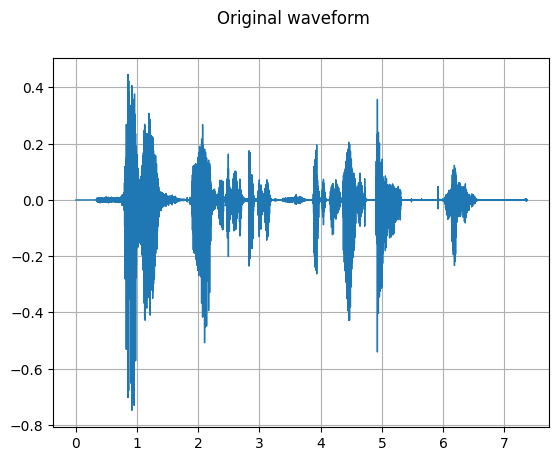

In [98]:

test_file = "audio/test.wav"
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(test_file)
plot_waveform(SPEECH_WAVEFORM.numpy(), SAMPLE_RATE, title="Original waveform")
ipd.Audio(SPEECH_WAVEFORM, rate=SAMPLE_RATE)


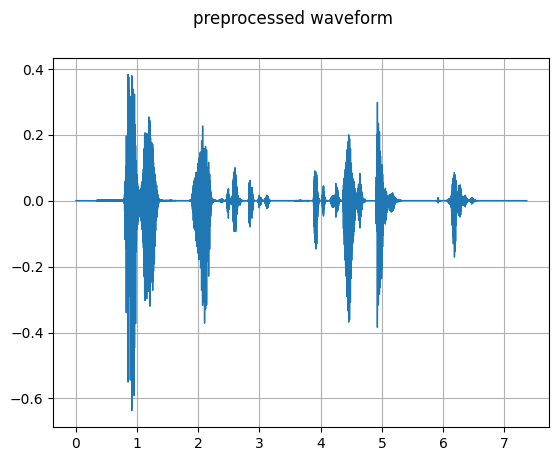

In [99]:
test_file = "audio/test.wav"
SPEECH_WAVEFORM, SAMPLE_RATE = preprocess_wav(test_file)
plot_waveform(np.array(SPEECH_WAVEFORM), SAMPLE_RATE, title="preprocessed waveform")
ipd.Audio(SPEECH_WAVEFORM, rate=SAMPLE_RATE)

In [50]:
melspec = mel_spectrogram(SPEECH_WAVEFORM)
print(melspec.shape)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

NameError: name 'mel_spectrogram' is not defined

## Przygotowanie danych

In [1]:
N_SPEAKERS = 5
CLASSES = N_SPEAKERS + 2
EPOCHS = 100
BATCH_SIZE = 8
LEARNING_RATE = 1e-7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.1220, 0.1220, 0.1220], [0.2058, 0.2058, 0.2058])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.1220, 0.1220, 0.1220], [0.2058, 0.2058, 0.2058])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.1220, 0.1220, 0.1220], [0.2058, 0.2058, 0.2058])
    ]),
}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_ROOT, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=4)
               for x in ['train', 'val', 'test']}

In [ ]:
DATASET_SIZES = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
CLASS_NAMES = image_datasets['train'].classes
print(CLASS_NAMES)

## Przygotowanie sieci konwolucyjnej
### Transfer wiedzy
W systemie skorzystano z metody transferu wiedzy, która polega na użyciu sieci neuronowej wytrenowanej wcześniej w innym, podobnym celu.

Istnieją dwa główne podejścia do transferu wiedzy. Pierwszy polega na zainicjowaniu sieci z wykorzystaniem wstępnie wytrenowanych wag zamiast inicjalizacji losowej i dalszym trenowaniu z wykorzystaniem docelowych danych. Drugie podejście polega na adaptacji wstępnie wyszkolonej sieci jako ekstraktora cech, w którym tylko ostatnia, w pełni połączona warstwa jest losowa inicjowana i trenowana.

W systemie zastosowano drugie podejście i wykorzystano sieć SqueezeNet, wytrenowaną w celu rozpoznawania obiektów za pomocą zbioru danych ImageNet.

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_1', weights=models.SqueezeNet1_1_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model.classifier._modules["1"] = nn.Sequential(
    nn.Conv2d(512, CLASSES, kernel_size=(1, 1)),
    nn.Softmax(dim=1)
)
model.num_classes = CLASSES

m_squeezenet = model.to(device)

### Parametry uczenia

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = None

### Uczenie

In [ ]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = {'train': [],
              'val': []}
    accs = {'train': [],
              'val': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / DATASET_SIZES[phase]
            epoch_acc = running_corrects.double() / DATASET_SIZES[phase]

            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc}')

    model.load_state_dict(best_model_wts)
    return model, losses, accs

In [ ]:
model, loss, acc= train_model(model,
                              criterion,
                              optimizer,
                              scheduler,
                              num_epochs=EPOCHS)

torch.save(model, f'speaker_recognition_model.pt')